In [1]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.10.0
GPU is ON


## Load Data

In [82]:
def _delete_duplicte (df):
    df_2 = df.copy()
    for i in range(1, len(df)):
        if df.iloc[i].date == df.iloc[i-1].date:
            df_2 = df_2.drop(df_2[df_2.date == df.iloc[i].date].index)
            n_count = df.iloc[i]['count'] + df.iloc[i-1]['count']
            new_row = {'date':df.iloc[i].date, 'count':n_count}
            df_2 = df_2.append(new_row, ignore_index=True)
    return df_2

In [95]:
df = pd.read_csv('96sku265.csv', sep = ",", parse_dates = ['date'])  #
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)

In [96]:
df = _delete_duplicte(df)
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)
date = df['date']
df = df.set_index('date')
s = pd.Series(df.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df.reset_index().date)[0], list(df.reset_index().date)[-1]), fill_value=0)
df = s.to_frame(name='count')
df.index.name='date'

In [97]:
df_week = df.reset_index()
df_week['date'] = pd.to_datetime(df_week['date']) - pd.to_timedelta(7, unit='d')
df_week = df_week.groupby([pd.Grouper(key='date', freq='W-MON')])['count'].sum()
df_week = df_week.to_frame(name='count')

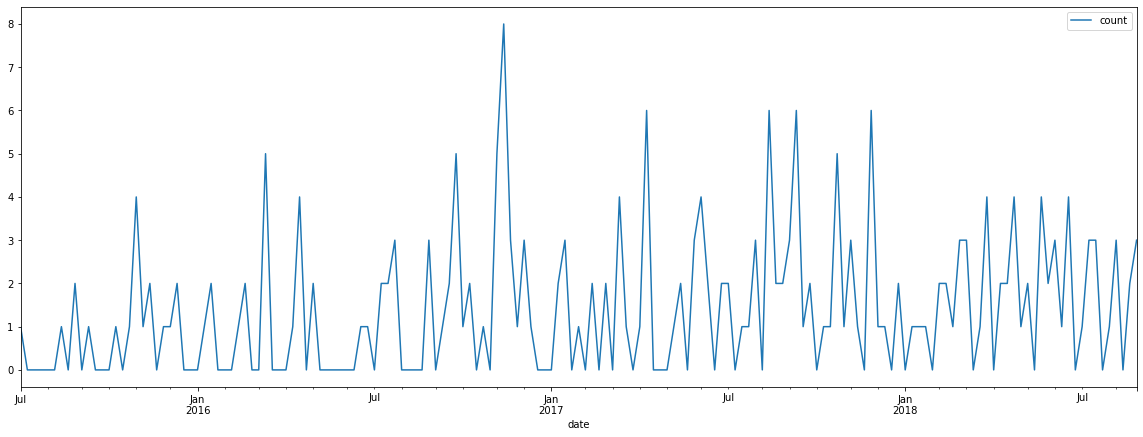

In [107]:
df_week.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

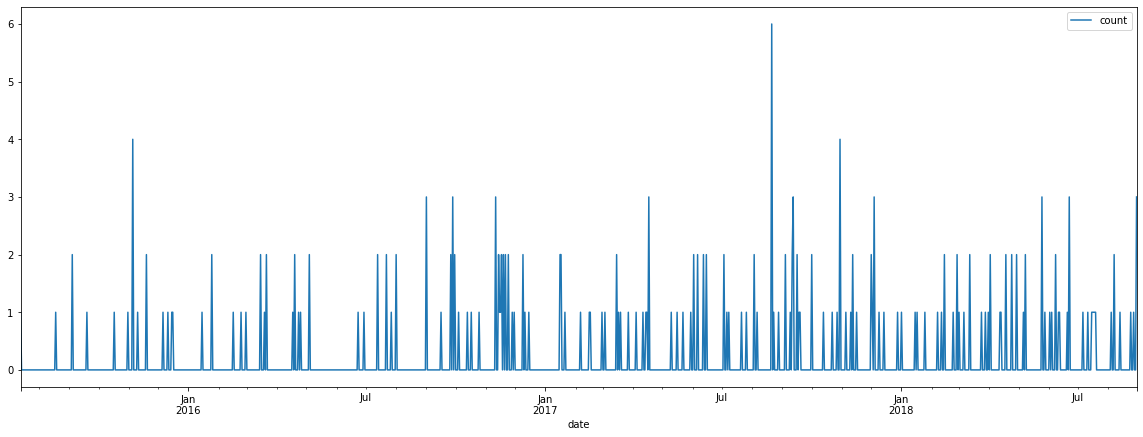

In [108]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Create Test/Train Data 

In [179]:
end_point = round(0.7*len(df_week))
start_point = -round(0.3*len(df_week))
train = df_week.iloc[:end_point]
test = df_week.iloc[start_point:]

In [180]:
# d = 800
# train = df.iloc[:d]
# test = df.iloc[d:]

In [181]:
len(train), len(test)

(115, 50)

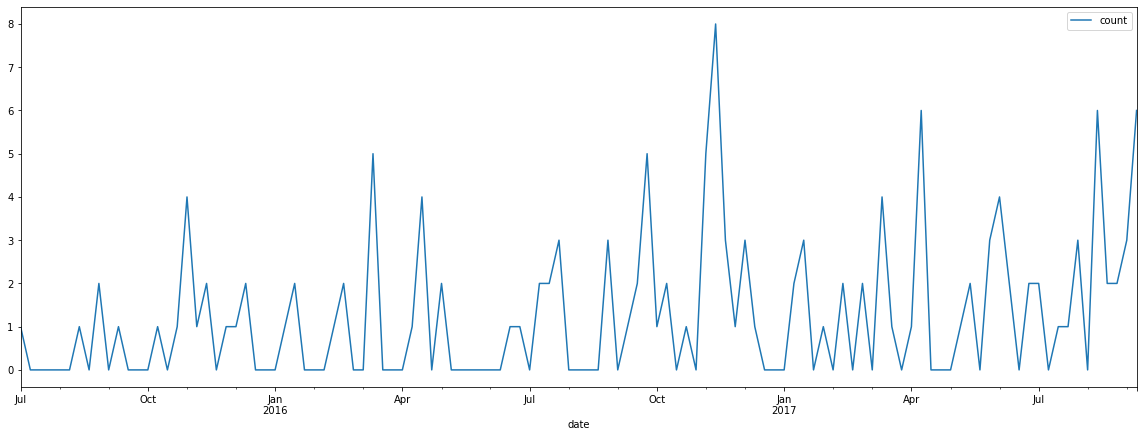

In [182]:
train.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

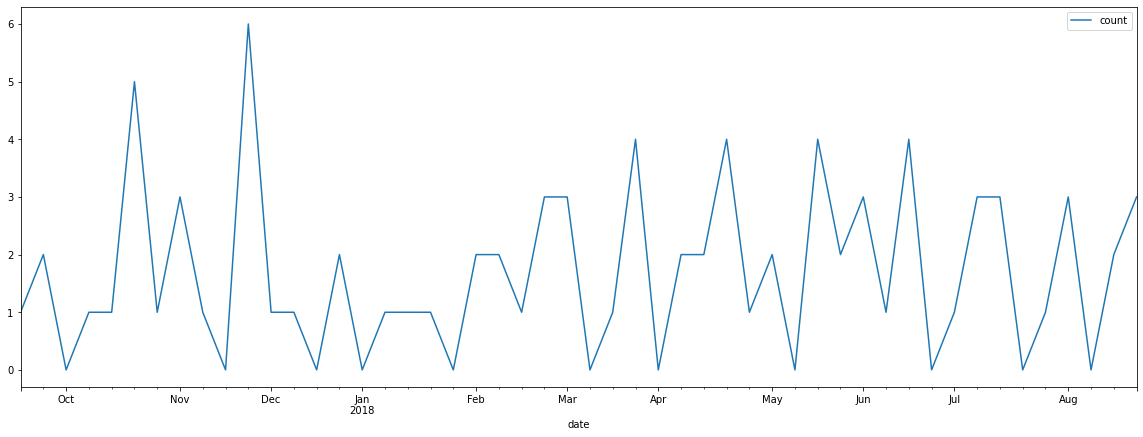

In [183]:
test.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [184]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 4
n_features = 1

generator_train = TimeseriesGenerator(np.array(train), np.array(train), length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(np.array(test), np.array(test), length=n_input, batch_size=1)

X,y = generator_train[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1 0 0 0]
Predict this y: 
 [[0]]


## Make a Model 

In [185]:
def buying_score(y_true, y_pred):
    return (1+y_pred)/(1+y_true)

In [186]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, ReLU, SimpleRNN, Lambda, Conv1D, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Input(shape=(n_input, n_features)))

# model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"))
# model.add(Bidirectional(LSTM(30, return_sequences=True)))
# model.add(SimpleRNN(50, activation="relu"))

model.add(SimpleRNN(10, activation="relu"))          
model.add(Dense(n_features))

model.compile(optimizer=Adam(), loss='mse', metrics=['mse', buying_score]) # tf.keras.losses.Huber()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [187]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [188]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        mse = logs["mse"]
        buying_score = logs["buying_score"]
        if (mse <= self.point) or ( mse >= 8):
            self.model.stop_training = True


In [189]:
model.fit(generator_train,epochs=1000 ,callbacks = [lr_schedule, StopOnPoint(0.1)])

Epoch 1/1000
111/111 [==============================] - 1s 6ms/step - loss: 4.3833 - mse: 4.3833 - buying_score: 0.6674 - lr: 1.0000e-08
Epoch 2/1000
111/111 [==============================] - 1s 6ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.1220e-08
Epoch 3/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.2589e-08
Epoch 4/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.4125e-08
Epoch 5/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.5849e-08
Epoch 6/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.7783e-08
Epoch 7/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.3832 - mse: 4.3832 - buying_score: 0.6674 - lr: 1.9953e-08
Epoch 8/1000
111/111 [===================

111/111 [==============================] - 1s 7ms/step - loss: 4.3040 - mse: 4.3040 - buying_score: 0.6886 - lr: 8.9125e-06
Epoch 61/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2949 - mse: 4.2949 - buying_score: 0.6915 - lr: 1.0000e-05
Epoch 62/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2846 - mse: 4.2846 - buying_score: 0.6938 - lr: 1.1220e-05
Epoch 63/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2732 - mse: 4.2732 - buying_score: 0.6975 - lr: 1.2589e-05
Epoch 64/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2611 - mse: 4.2611 - buying_score: 0.7005 - lr: 1.4125e-05
Epoch 65/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2473 - mse: 4.2473 - buying_score: 0.7040 - lr: 1.5849e-05
Epoch 66/1000
111/111 [==============================] - 1s 7ms/step - loss: 4.2325 - mse: 4.2325 - buying_score: 0.7083 - lr: 1.7783e-05
Epoch 67/1000
111/111 [=========================

Epoch 120/1000
111/111 [==============================] - 1s 7ms/step - loss: 2.6287 - mse: 2.6287 - buying_score: 1.4232 - lr: 0.0089
Epoch 121/1000
111/111 [==============================] - 1s 8ms/step - loss: 2.7340 - mse: 2.7340 - buying_score: 1.4119 - lr: 0.0100
Epoch 122/1000
111/111 [==============================] - 1s 7ms/step - loss: 2.7034 - mse: 2.7034 - buying_score: 1.4472 - lr: 0.0112
Epoch 123/1000
111/111 [==============================] - 1s 7ms/step - loss: 2.6969 - mse: 2.6969 - buying_score: 1.3644 - lr: 0.0126
Epoch 124/1000
111/111 [==============================] - 1s 7ms/step - loss: 2.5521 - mse: 2.5521 - buying_score: 1.3633 - lr: 0.0141
Epoch 125/1000
111/111 [==============================] - 1s 7ms/step - loss: 2.9553 - mse: 2.9553 - buying_score: 1.4681 - lr: 0.0158
Epoch 126/1000
111/111 [==============================] - 1s 8ms/step - loss: 2.6559 - mse: 2.6559 - buying_score: 1.4396 - lr: 0.0178
Epoch 127/1000
111/111 [==============================]

In [ ]:
plt.figure(0)
plt.plot(model.history.history['mse'], label='training mse')
# plt.plot(model.history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
# plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [146]:
# model.save('bestBIG.h5')

# Test Model

## Normalised data

In [147]:
test_predictions = []
first_eval_batch = np.array(test)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    test_predictions.append(np.array(test)[i]) 
    
try:
    for i in range(len(test)-3):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        print(current_pred)
        if current_pred < 0: current_pred = current_pred*(-1)
        test_predictions.append([current_pred])#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(test)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 349ms/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [======================

In [148]:
test_predictions

[array([1], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([5], dtype=int64),
 array([1], dtype=int64),
 array([3], dtype=int64),
 array([1], dtype=int64),
 [1],
 [2],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [2],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [2],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]]

In [149]:
test_copy = test.copy()
test_copy['Predictions'] = np.array(test_predictions)
test_copy

,count,Predictions
date,,
2017-09-18,1,1
2017-09-25,2,2
2017-10-02,0,0
2017-10-09,1,1
2017-10-16,1,1
2017-10-23,5,5
2017-10-30,1,1
2017-11-06,3,3
2017-11-13,1,1


<AxesSubplot:xlabel='date'>

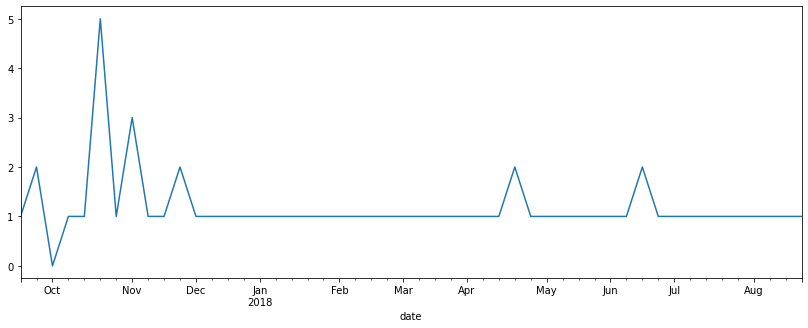

In [150]:
test_copy['Predictions'].plot(figsize=(14,5))


<AxesSubplot:xlabel='date'>

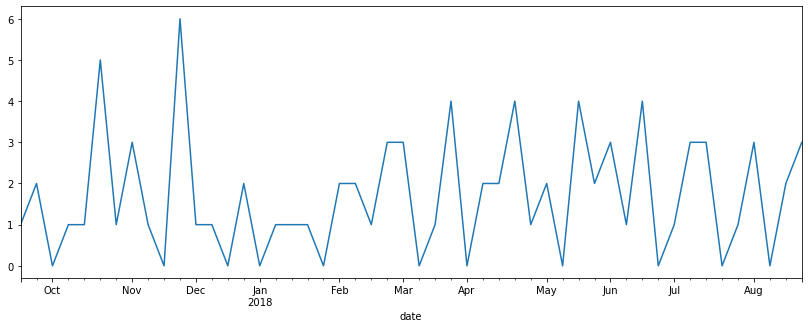

In [151]:
test_copy['count'].plot(figsize=(14,5))


<AxesSubplot:xlabel='date'>

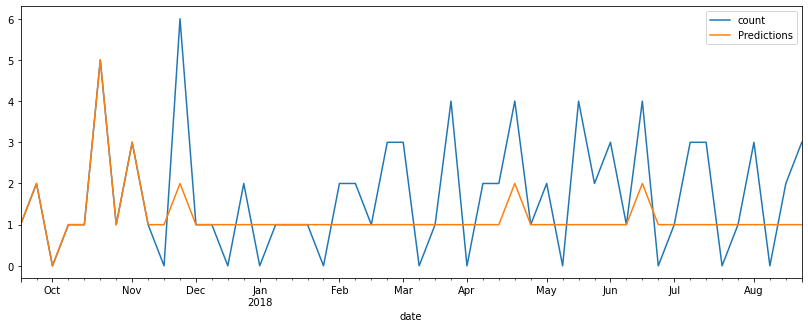

In [152]:
test_copy.plot(figsize=(14,5))


In [153]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
#     if y_true != y_pred:
#         print(y_true, y_pred, buying_score(y_true, y_pred))
    metric_list.append(buying_score(y_true, y_pred))

In [154]:
mean(metric_list)

1.0252380952380953

In [155]:
Bought = sum(list(test_copy['Predictions']))
Sold = sum(list(test_copy['count']))
Bought, Sold

(59, 85)

In [156]:
print('Перезакуп {}'.format (Bought - Sold)) if Bought/Sold > 1 else print('Недозакуп {}'.format (Bought - Sold))

Недозакуп -26


In [157]:
Bought/Sold

0.6941176470588235

## Predict New Month

In [ ]:
new_predictions = []
first_eval_batch =  np.array(test)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)[0]
        new_predictions.append(round(current_pred[0])) 
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
except:
    pass

In [ ]:
test_copy_3 = test.copy()
test_copy_3

In [ ]:
test_copy_3.index.name='date'


In [ ]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_3.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [ ]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions
predicted_df = predicted_df.set_index('date')

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(df)
plt.plot(predicted_df)
plt.show()

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(test_copy_3)
plt.plot(predicted_df)
plt.show()

## Check second SKU

In [ ]:
df_2 = pd.read_csv('42sku13653.csv', sep = ",", parse_dates = ['date']) # 

In [ ]:
df_2 = _delete_duplicte(df_2)
df_2 = df_2.sort_values(by=['date'])
df_2 = df_2.reset_index().drop('index', axis=1)
date = df_2['date']
df_2 =df_2.set_index('date')
s = pd.Series(df_2.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df_2.reset_index().date)[0], list(df_2.reset_index().date)[-1]), fill_value=0)
df_2 = s.to_frame(name='count')

In [ ]:
df_2

In [ ]:
df_2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [ ]:
df2_predictions = []
first_eval_batch = np.array(df_2)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    df2_predictions.append(np.array(df_2)[i][0]) 
    
try:
    for i in range(len(np.array(df_2))-3):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        if current_pred < 0: current_pred = current_pred*(-1)
        print(current_pred)
        df2_predictions.append(current_pred)#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df_2)[n_input+i]]],axis=1)
except:
    pass

In [ ]:
test_copy_DF2 = df_2.copy()
test_copy_DF2['Predictions'] = np.array(df2_predictions)
test_copy_DF2

In [ ]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy_DF2['count'],test_copy_DF2['Predictions'])

In [ ]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy_DF2['count']),list(test_copy_DF2['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

In [ ]:
s = sum(list(test_copy_DF2['count']))
b = sum(list(test_copy_DF2['Predictions']))
b-s

In [ ]:
b/s

In [ ]:
test_copy_DF2['count'].plot(figsize=(14,5))


In [ ]:
test_copy_DF2['Predictions'].plot(figsize=(14,5))


In [ ]:
test_copy_DF2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Predict New Month for second SKU

In [ ]:
new_predictions_2 = []
first_eval_batch =  np.array(df_2)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)[0]
        print(current_pred[0])
        current_pred = round(current_pred[0])
        print(current_pred)
        if current_pred < 0: current_pred = current_pred*(-1)
        print(current_pred)
        new_predictions_2.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
except:
    pass

In [ ]:
new_predictions_2 = []
first_eval_batch =  np.array(df_2)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        if current_pred < 0: current_pred = current_pred*(-1)
        print(current_pred)
        new_predictions_2.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

In [ ]:
test_copy_DF2.index.name='date'
 

In [ ]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_DF2.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [ ]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions_2
predicted_df = predicted_df.set_index('date')

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(df_2)
plt.plot(predicted_df)
plt.show()